# Fetching Historical Data using yfinance
I am using the top 10 aerospace and defense companies from Yahoo Finance.

In [30]:
# import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

ticker_list = ['GE', 'RTX', 'BA', 'LMT', 'TDG', 'GD', 'HWM', 'NOC', 'AXON', 'LHX']
data = yf.download(ticker_list, start='2024-06-16', end='2025-06-16')

/var/folders/sx/1hm8tkl152z03tg5g8wfh9y40000gn/T/ipykernel_87520/1201546617.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, start='2024-06-16', end='2025-06-16')
[*********************100%***********************]  10 of 10 completed


In [7]:
# create a pandas DataFrame of just the closing prices
data_close = pd.DataFrame(data['Close'])

In [8]:
data_close

Ticker,AXON,BA,GD,GE,HWM,LHX,LMT,NOC,RTX,TDG
Date,,,,,,,,,,
2024-06-17,297.170013,178.389999,286.360046,161.910400,79.760315,216.293457,447.215271,422.362762,102.321320,1249.204590
2024-06-18,293.519989,174.990005,290.424042,163.636337,79.959717,218.018387,448.179810,418.480927,102.615143,1268.687378
2024-06-20,293.140015,176.300003,292.012604,163.666092,79.271790,219.635513,454.356903,426.981659,102.908981,1259.395996
2024-06-21,291.149994,176.559998,290.667694,162.912231,79.899902,221.017410,455.584564,424.632874,103.437866,1251.269287
2024-06-24,292.700012,179.100006,290.940582,159.242126,78.394417,220.997833,459.394073,423.237396,99.862946,1257.861572
...,...,...,...,...,...,...,...,...,...,...
2025-06-09,783.799988,217.509995,275.894775,251.043396,172.869995,245.410004,480.829987,491.359985,140.979996,1460.060059
2025-06-10,762.659973,215.729996,275.954468,241.647110,168.619995,244.789993,476.899994,488.799988,138.520004,1433.040039
2025-06-11,778.359985,214.000000,274.422302,245.161987,170.740005,246.669998,456.600006,488.459991,141.809998,1429.619995


In [9]:
# export the data to a csv file
data_close.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/stock_data.csv')

# Computing the Spread of the Time Series

In [54]:
# create combinations of the stocks
pair_list = combinations(ticker_list, 2)
data_spread = pd.DataFrame()
spread_stats = []

# for each pair, calculate mean and spread
for ticker1, ticker2 in pair_list:
        # store spread time series
        spread = data_close[ticker1] - data_close[ticker2]
        col_name = f"{ticker1}-{ticker2}"
        data_spread[col_name] = spread
        
        # compute stats
        mean = spread.mean()
        std = spread.std()
        range_value = spread.max() - spread.min()

        spread_stats.append({
                "Ticker 1": ticker1,
                "Ticker 2": ticker2,
                "Mean": mean,
                "Standard Deviation": std,
                "Range": range_value 
        })
spread_stats = pd.DataFrame(spread_stats)

In [55]:
data_spread 

,GE-RTX,GE-BA,GE-LMT,GE-TDG,GE-GD,GE-HWM,GE-NOC,GE-AXON,GE-LHX,RTX-BA,...,GD-HWM,GD-NOC,GD-AXON,GD-LHX,HWM-NOC,HWM-AXON,HWM-LHX,NOC-AXON,NOC-LHX,AXON-LHX
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-17,59.589081,-16.479599,-285.304871,-1087.294189,-124.449646,82.150085,-260.452362,-135.259613,-54.383057,-76.068680,...,206.599731,-136.002716,-10.809967,70.066589,-342.602448,-217.409698,-136.533142,125.192749,206.069305,80.876556
2024-06-18,61.021194,-11.353668,-284.543472,-1105.051041,-126.787704,83.676620,-254.844589,-129.883652,-54.382050,-72.374863,...,210.464325,-128.056885,-3.095947,72.405655,-338.521210,-213.560272,-138.058670,124.960938,200.462540,75.501602
2024-06-20,60.757111,-12.633911,-290.690811,-1095.729904,-128.346512,84.394302,-263.315567,-129.473923,-55.969421,-73.391022,...,212.740814,-134.969055,-1.127411,72.377090,-347.709869,-213.868225,-140.363724,133.841644,207.346146,73.504501
2024-06-21,59.474365,-13.647766,-292.672333,-1088.357056,-127.755463,83.012329,-261.720642,-128.237762,-58.105179,-73.122131,...,210.767792,-133.965179,-0.482300,69.650284,-344.732971,-211.250092,-141.117508,133.482880,203.615463,70.132584
2024-06-24,59.379181,-19.857880,-300.151947,-1098.619446,-131.698456,80.847710,-263.995270,-133.457886,-61.755707,-79.237061,...,212.546165,-132.296814,-1.759430,69.942749,-344.842979,-214.305595,-142.603416,130.537384,202.239563,71.702179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,110.063400,33.533401,-229.786591,-1209.016663,-24.851379,78.173401,-240.316589,-532.756592,5.633392,-76.529999,...,103.024780,-215.465210,-507.905212,30.484772,-318.489990,-610.929993,-72.540009,-292.440002,245.949982,538.389984
2025-06-10,103.127106,25.917114,-235.252884,-1191.392929,-34.307358,73.027115,-247.152878,-521.012863,-3.142883,-77.209991,...,107.334473,-212.845520,-486.705505,31.164474,-320.179993,-594.039978,-76.169998,-273.859985,244.009995,517.869980
2025-06-11,103.351990,31.161987,-211.438019,-1184.458008,-29.260315,74.421982,-243.298004,-533.197998,-1.508011,-72.190002,...,103.682297,-214.037689,-503.937683,27.752304,-317.719986,-607.619980,-75.929993,-289.899994,241.789993,531.689987


In [56]:
spread_stats

,Ticker 1,Ticker 2,Mean,Standard Deviation,Range
0,GE,RTX,66.038531,15.349974,72.584717
1,GE,BA,15.244769,19.678140,73.640686
2,GE,LMT,-308.896365,58.226113,200.925964
3,GE,TDG,-1124.950991,58.984560,286.574371
4,GE,GD,-89.168718,31.148500,111.886658
5,GE,HWM,70.798279,9.804519,38.859467
6,GE,NOC,-296.477331,34.458037,136.632828
7,GE,AXON,-331.002341,127.021577,416.137253
8,GE,LHX,-37.363171,26.448491,95.016388
9,RTX,BA,-50.793762,17.714419,71.080856


In [57]:
data_spread.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/data_spread.csv')

In [58]:
spread_stats.to_csv('/Users/ashleytran/Desktop/URE25/pairs-trading/data/spread_stats.csv')

# Compute the Correlation
Use Pearson's r correlation to filter the highest correlated pairs to then test for cointegration. First compute the log returns.

In [59]:
# compute log returns and drop the first day
log_returns = np.log(data_close / data_close.shift(1))
log_returns.dropna()


Ticker,AXON,BA,GD,GE,HWM,LHX,LMT,NOC,RTX,TDG
Date,,,,,,,,,,
2024-06-18,-0.012359,-0.019243,0.014092,0.010603,0.002497,0.007943,0.002154,-0.009233,0.002867,0.015476
2024-06-20,-0.001295,0.007458,0.005455,0.000182,-0.008641,0.007390,0.013689,0.020110,0.002859,-0.007351
2024-06-21,-0.006812,0.001474,-0.004616,-0.004617,0.007892,0.006272,0.002698,-0.005516,0.005126,-0.006474
2024-06-24,0.005310,0.014284,0.000938,-0.022786,-0.019022,-0.000089,0.008327,-0.003292,-0.035172,0.005255
2024-06-25,-0.000239,-0.022587,-0.010946,-0.005058,-0.005484,-0.004356,-0.007322,-0.005098,-0.003832,-0.005807
...,...,...,...,...,...,...,...,...,...,...
2025-06-09,-0.010218,0.031335,0.002997,-0.016646,-0.014358,0.004656,-0.001787,0.003976,0.013425,-0.003985
2025-06-10,-0.027342,-0.008217,0.000216,-0.038147,-0.024892,-0.002530,-0.008207,-0.005224,-0.017603,-0.018679
2025-06-11,0.020377,-0.008052,-0.005568,0.014441,0.012494,0.007651,-0.043499,-0.000696,0.023473,-0.002389


In [60]:
# compute Pearson correlation
corr_matrix = log_returns.corr()
corr_matrix

Ticker,AXON,BA,GD,GE,HWM,LHX,LMT,NOC,RTX,TDG
Ticker,,,,,,,,,,
AXON,1.000000,0.248146,0.216016,0.407783,0.390790,0.225891,0.097202,0.068460,0.262851,0.249714
BA,0.248146,1.000000,0.315540,0.503490,0.476223,0.151695,0.084096,0.105899,0.405786,0.428402
GD,0.216016,0.315540,1.000000,0.475818,0.448151,0.657914,0.575405,0.465159,0.558262,0.573192
GE,0.407783,0.503490,0.475818,1.000000,0.695864,0.347434,0.272683,0.109701,0.438826,0.666607
HWM,0.390790,0.476223,0.448151,0.695864,1.000000,0.355112,0.201828,0.118531,0.498785,0.626510
LHX,0.225891,0.151695,0.657914,0.347434,0.355112,1.000000,0.605436,0.507519,0.488557,0.466637
LMT,0.097202,0.084096,0.575405,0.272683,0.201828,0.605436,1.000000,0.566326,0.399034,0.338288
NOC,0.068460,0.105899,0.465159,0.109701,0.118531,0.507519,0.566326,1.000000,0.678444,0.295954
RTX,0.262851,0.405786,0.558262,0.438826,0.498785,0.488557,0.399034,0.678444,1.000000,0.499744


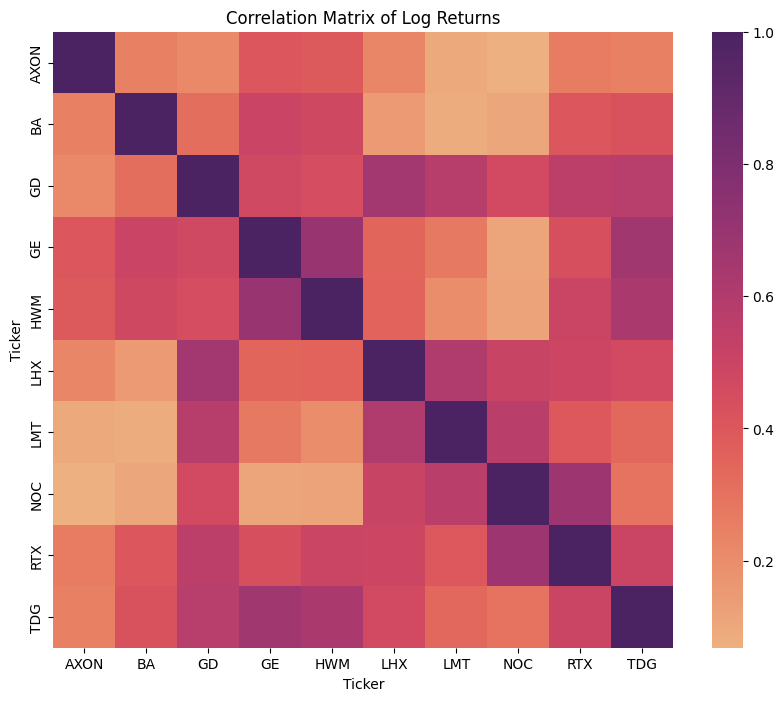

In [61]:
# plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='flare')

plt.title('Correlation Matrix of Log Returns')
plt.show()

483.9957275390625
